In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:

class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.stem(x)

In [4]:
class BottleNeck(nn.Module):
    '''BottleNeck
    BottleNeck은 일반적으로 ( 1 * 1 -> 3 * 3 -> 1 * 1) 형태를 지닙니다.
    그리고 in_channels, hidden_channels, expansion을 필요로 합니다.
    expansion = out_channels / hidden_channels 이며 주로 ( in_c -> hi_c -> hi_c * expansin ) 으로 채널을 구성합니다.
    '''
    global expansion
    def __init__(self, in_channels, hidden_channels, stride=2):
        super().__init__()
        expansion = 4
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels * expansion, kernel_size=1, stride=1),
            nn.BatchNorm2d(hidden_channels),
        )

        self.downsample = None
        if in_channels != hidden_channels * expansion or stride !=1 :
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels = in_channels, out_channels = hidden_channels * expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(hidden_channels * expansion),
            )


    def forward(self, x) :
        identity = x
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        if self.downsample is not None :
            identity = self.downsample(identity)

        return F.relu(identity + x)


In [6]:
def window_partition(x, window):
    B, C, H, W = x.size()
    x = x.view(B, C, H // window, window, W // window, window)
    x = x.permute(0,2,4,3,5,1)
    x= x.contiguous().view(-1, window * window, C)
    print(f'window_parition에서 반환하는 데이터 사이즈 : {x.size()}')
    return x


In [7]:
def window_reverse(windows, window_size, H, W) :
    '''
    windows : 총 토큰의 수
    window_size : 토큰 하나의 사이즈
    H, W : 원래 이미지의 크기
    토큰 수가 64개인 경우, window_size = 256 -> 즉 ( 64 / (8 * 8 ) = 1 )
    '''
    B = int(windows.shape[0] / ( ( H // window_size ) * (W // window_size)))
    # window_parition의 반대로 다시 펼쳐준다.
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    # 이후 permuate를 통해서 원래 형태로 복원 시켜준다. ( 배치, 채널, 높이, 너비 )
    x = x.permute(0,5,1,3,2,4).contiguous().view(B,-1,H,W)
    return x




변경 전 크기 : (2048, 2048)
변경 후 크기: (256, 256)
image size : torch.Size([1, 3, 256, 256])
window_parition에서 반환하는 데이터 사이즈 : torch.Size([64, 1024, 3])


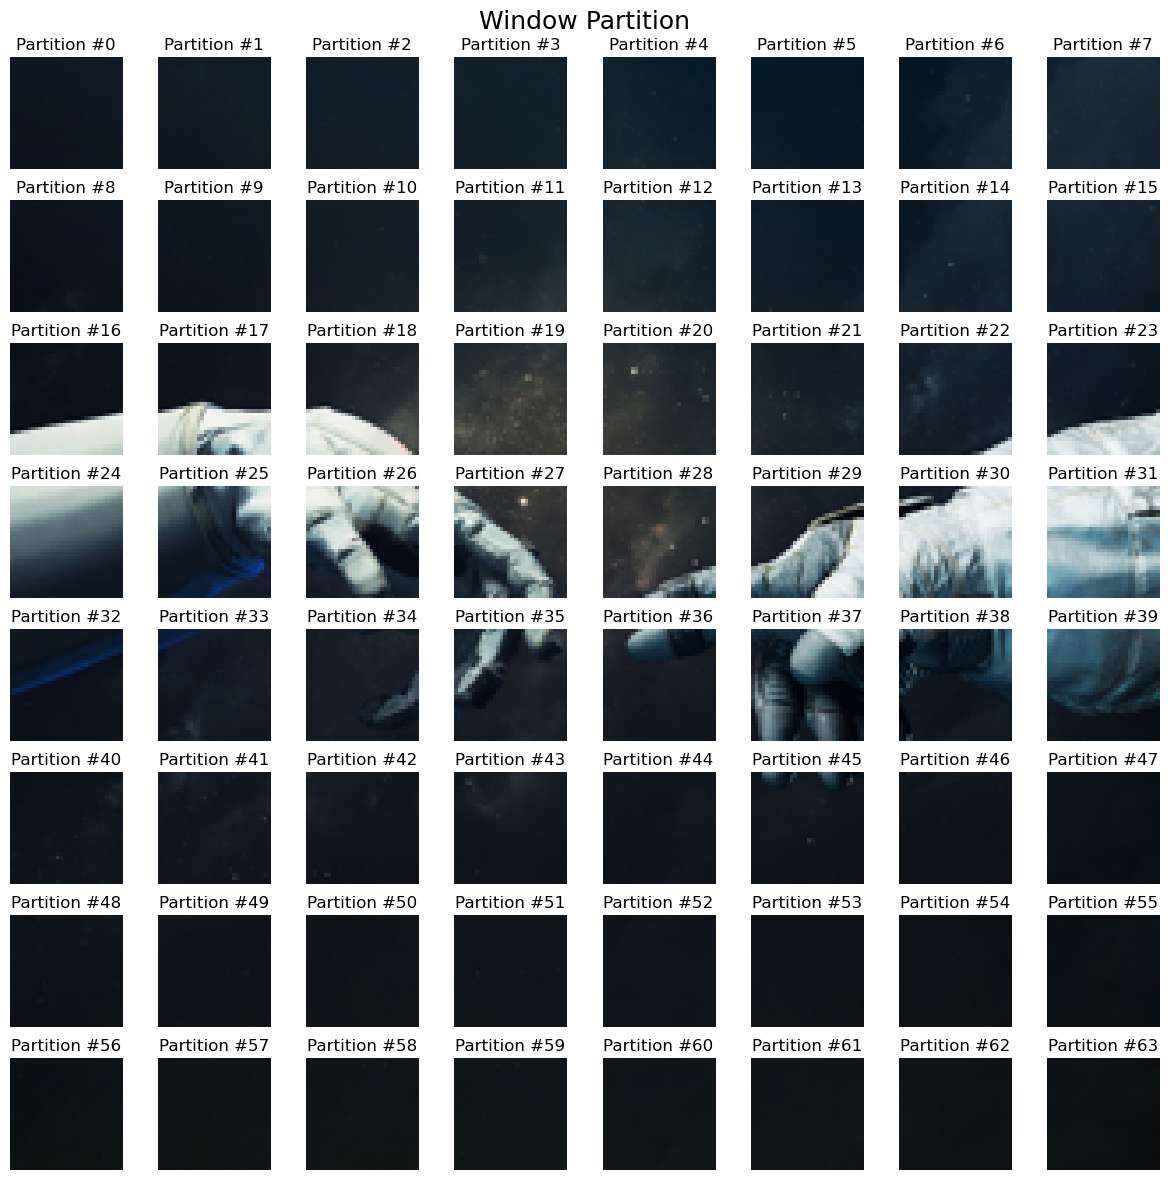

Text(0.5, 1.0, 'Window Reverse')

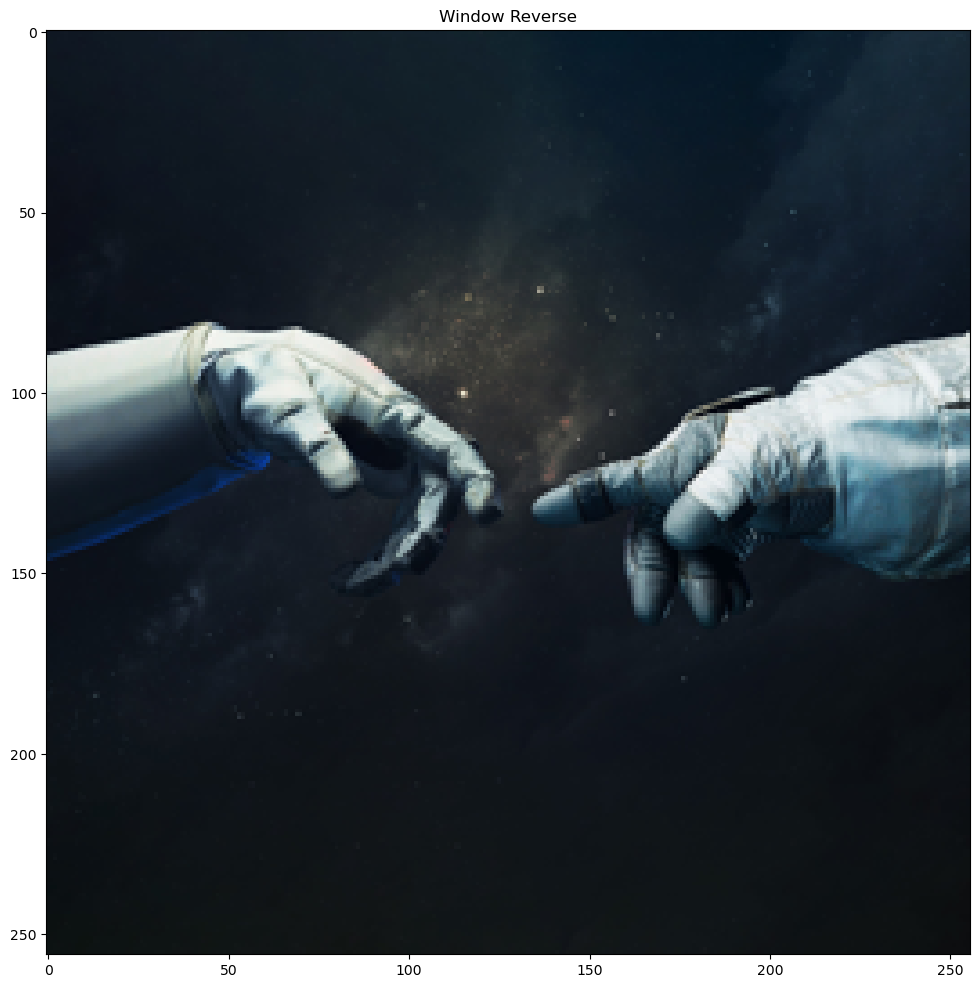

In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# img = Image.open('/content/drive/MyDrive/cat_dog.jpg')
img = Image.open('/Users/jeongseungmin/Desktop/Study/JSM/Pose_Estimation/HRFormer/example_image.jpeg')

print(f'변경 전 크기 : {img.size}')
new_size = (256, 256)
img = img.resize((256, 256))

print('변경 후 크기:', img.size)


arr = np.array(img)
image = torch.from_numpy(arr)
image = image.unsqueeze(0).permute(0,3,1,2).float()
print(f'image size : {image.size()}')
image_size = image.size(-1)
number_patchs = 8

window_size = image.size(2) // number_patchs # 일단은 모든 이미지에 대해서 총 4개의 파티션을 나눈다는 생각

splited_window = window_partition(image, window_size)


fig, axes = plt.subplots(
    nrows=image_size // window_size,
    ncols=image_size // window_size,
    figsize=(12,12)
)

# add a title for the entire figure
fig.suptitle("Window Partition", fontsize=18)

for idx, patch in enumerate(splited_window):
    patch = patch.view(window_size, window_size, -1).cpu().numpy().astype('uint8')
    r, c = divmod(idx, number_patchs)
    ax = axes[r][c]
    ax.imshow(patch)
    ax.set_title(f"Partition #{idx}")
    ax.axis('off')

# if the suptitle overlaps the subplots, you can push them down a bit
plt.subplots_adjust(top=0.92)

plt.tight_layout()
plt.show()


image = window_reverse(splited_window, window_size, image_size, image_size)
image = image.cpu().squeeze(0).permute(1,2,0) / 255

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.imshow(image)
ax.set_title('Window Reverse')


In [ ]:
class WindowAttention(nn.Module):
    def __init__(self, dim, num_head, window_size, qkv_bias=False):
        super().__init__()
        self.dim = dim
        self.num_head = num_head
        self.window_size = window_size
        self.head_dim = dim // num_head

        self.qkv = nn.Linear(self.dim, self.dim * 3, bias=qkv_bias)
        self.project = nn.Linear(self.dim, self.dim)
        self.softmax = nn.Softmax(dim = -1)
        self.scale = self.dim ** -0.5

    def forward(self, x):
        B_, N, C  = x.size()
        qkv = self.qkv(x)
        qkv = qkv.reshape(B_, N, 3, self.num_head, C // self.num_head)
        qkv = qkv.permute(2, 0, 3, 1, 4).contiguous()
        q, k, v = qkv[0], qkv[1], qkv[-1]

        attn = self.softmax( q @ k.transpose(-2,-1) * self.scale ) @ v
        x = attn.transpose(1,2) # attn의 경우 [ B_, num_head, N, C // num_head ] 인데 이를 마지막에 [ B, N , C] 로만들어주기 위해서 자리를 바꿔준다.
        x = x.reshape(B_, N, C)
        x = self.project(x)

        return x


변경 전 크기 : (2048, 2048)
변경 후 크기: (256, 256)
image size : torch.Size([1, 3, 256, 256])
window_parition에서 반환하는 데이터 사이즈 : torch.Size([64, 1024, 3])
torch.Size([1024, 3])


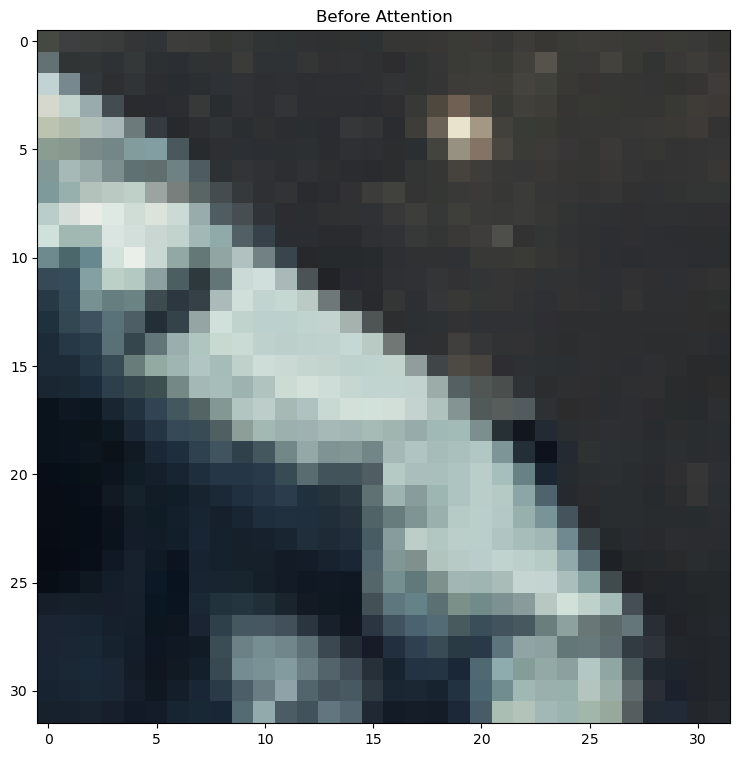

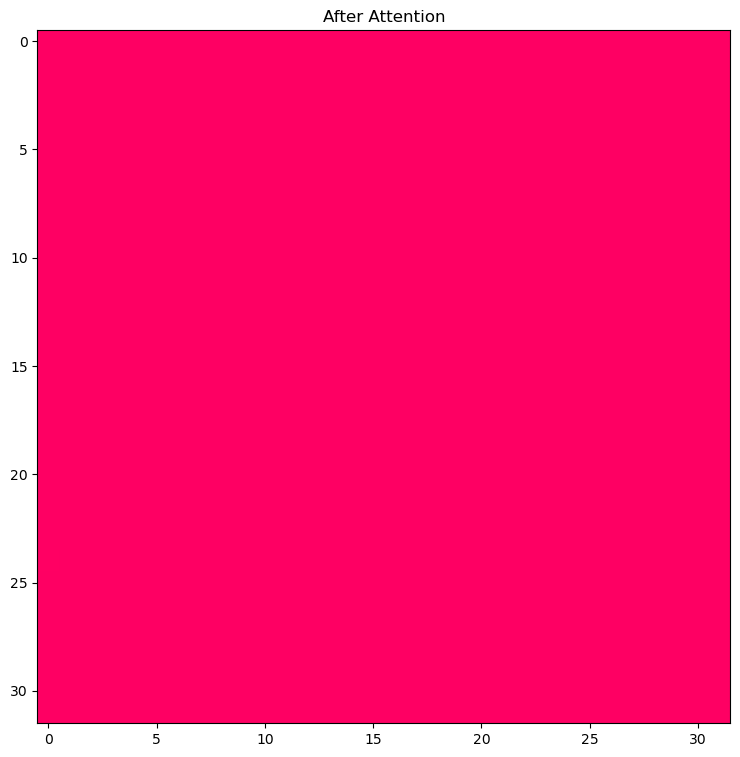

In [10]:
# img = Image.open('/content/drive/MyDrive/cat_dog.jpg')
img = Image.open('/Users/jeongseungmin/Desktop/Study/JSM/Pose_Estimation/HRFormer/example_image.jpeg')

print(f'변경 전 크기 : {img.size}')
new_size = (256, 256)
img = img.resize((256, 256))

print('변경 후 크기:', img.size)


arr = np.array(img)
image = torch.from_numpy(arr)
image = image.unsqueeze(0).permute(0,3,1,2).float()
print(f'image size : {image.size()}')
image_size = image.size(-1)
number_patchs = 8

window_size = image.size(2) // number_patchs

splited_window = window_partition(image, window_size)


idx = 27
image = splited_window[idx].reshape(window_size, window_size, -1).permute(0,1,2).cpu().numpy().astype('uint8')
figure = plt.figure(figsize=(9,9))
ax = figure.add_subplot(1,1,1)
ax.set_title(f'Before Attention')
ax.imshow(image)


print(splited_window[idx].size())


attention = WindowAttention(
    dim=3,
    num_head=1,
    window_size=window_size,
    qkv_bias=False
)


inp = splited_window[idx].unsqueeze(0).float()
out = attention(inp).squeeze(0)
out = out.view(window_size, window_size, 3).cpu().detach().numpy()

out = out - out.min()
out = out / (out.max() + 1e-6)
fig, ax = plt.subplots(1,1,figsize=(9,9))
ax.set_title('After Attention')
ax.imshow(out)


In [11]:
'''Conv2d(groups=[])
gropus 파라미터의 경우 입력으로 들어온 채널을 몇개의 그룹으로 나눌지 결정해줍니다.
일반적인 상황에서는 groups = 1 로 설정되어있어 ( kernel_size * kernel_size * c ) 가 하나의 필터가 되지만 
만일 grpus = in_channels인 경우 (kerne_size * kernel_size * 1 ) 이 하나의 필터가 되어서 채널별로 독립적으로 conv 연산이 진행되게 됩니다.
'''
class DWFFN(nn.Module):
    def __init__(self, dim , mlp_ratio):
        super().__init__()
        self.hidden_dim = int(dim * mlp_ratio)
        self.net = nn.Sequential(
            nn.Conv2d(dim, self.hidden_dim, kernel_size=1, bias=False),
            nn.GELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=3, padding=1, groups=self.hidden_dim, bias=False),
            nn.Conv2d(self.hidden_dim, dim, kernel_size=1, bias=False)
        )
    
    def forward(self,x):
        return self.net(x)

In [15]:
conv = nn.Conv2d(18, 18, kernel_size=3, padding=1, groups=6, bias=False)
print(f' 입력 채널이 18이고, 이를 총 6개의 그룹으로 나눌거니깐, 결국 사용되는 필터의 채널은 3이 된다, \n {conv.weight.shape}')

conv = nn.Conv2d(100, 100, kernel_size=3, padding=1, groups=25, bias=False)
print(f' 입력 채널이 100이고, 이를 총 25개의 그룹으로 나눌거니깐, 결국 사용되는 필터의 채널은 4이 된다, \n {conv.weight.shape}')


 입력 채널이 18이고, 이를 총 6개의 그룹으로 나눌거니깐, 결국 사용되는 필터의 채널은 3이 된다, 
 torch.Size([18, 3, 3, 3])
 입력 채널이 100이고, 이를 총 25개의 그룹으로 나눌거니깐, 결국 사용되는 필터의 채널은 4이 된다, 
 torch.Size([100, 4, 3, 3])


# BatchNorm VS LayerNorm
BatchNorm은 CNN에서 주로 쓰이는 정규화 기법으로, 입력 텐서가 (B, C, H, W) 형태일 때 배치 크기 B와 공간 축 H×W를 모두 합친 값들로 각 채널(C)별 평균과 분산을 계산합니다. 예를 들어 배치 크기가 8이고 채널 수가 12라면, 총 8×H×W개의 값을 모아 채널 0의 평균과 분산을 구하고, 다시 채널 1, 채널 2…를 순차적으로 계산한 뒤 각 채널을 평균 0, 분산 1에 가깝도록 표준화합니다. 이렇게 하면 배치 단위로 통계가 모여 모델이 더 안정적으로 학습됩니다.<br><br>


반면 LayerNorm은 배치나 공간 위치와 무관하게 “한 지점의 채널 벡터”만 보고 정규화하는 방식입니다. (B, C, H, W) 형태의 피처 맵을 (B, H, W, C)로 차원 순서를 바꾼 뒤, 각 픽셀 위치(h, w)의 C차원 벡터만을 가져와 그 안에서 평균과 분산을 계산하고 표준화합니다. 즉, 배치 크기 B와 공간 해상도 H×W는 전혀 고려되지 않으며, 오직 채널 C만을 기준으로 정규화가 이루어집니다. 이러한 특성 덕분에 LayerNorm은 Transformer나 ViT, HRFormer 같은 모델에서 배치 크기의 제약 없이 안정적으로 쓰입니다.

In [ ]:
class HRFormerBlock(nn.Module):
    def __init__(self, dim, num_head, window_size=7, mlp_ratio=4.0, qkv_bias=False):
        super().__init__()
        self.window_size = window_size
        self.dim = dim
        self.num_head = num_head
        self.mlp_ratio = mlp_ratio
        
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(self.dim, self.num_head, self.window_size, qkv_bias)

        self.norm2 = nn.LayerNorm(dim)
        self.ffn = DWFFN(self.dim, self.mlp_ratio)

    def forward(self,x):
        B,C,H,W = x.size()
        shortcut = x

        x_perm = x.permute(0,2,3,1).contigeous() # LayerNorm은 C 차원을 기준으로 하기 떄문에 C 차원을 마지막 차원으로 이동 시킨 후 다시 복귀시킨다.
        x_ln = self.norm1(x_perm).permute(0,3,1,2)
        x_windows = window_partition(x_ln, self.window_size)
        attn_windows = self.attn(x_windows)
        x_attn = window_reverse(attn_windows, self.window_size, H, W)
        x = shortcut + x

        shortcut2 = x
        x_ln2 = self.norm2(x.permute(0,2,3,1)).permute(0,3,1,2)
        x_ffn = self.ffn(x_ln2)

        return shortcut2 + x_ffn

In [16]:
# prev_channels = [18, 36]
# curr_channels =[18, 36, 72] 

def _make_transition_layer(prev_channels, curr_channels):
    layers = []
    for i, c_out in enumerate(curr_channels):
        # 새롭게 생기는 브랜치가 아니라, 기존에 존재했던 브랜치를 의미한다.
        if i < len(curr_channels):
            c_in = prev_channels[i]
            if c_out != c_in :
                layers.append(nn.Sequential(
                    nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
                    nn.BatchNorm2d(c_out),
                    nn.ReLU(inplace=True)
                ))
            else:
                layers.append(nn.Identity())
        
        # 만일 새로운 브랜치를 생성해야하는 경우
        else:
            c_in = prev_channels[-1]
            layers.append(nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True)
            ))
    return nn.ModuleList(layers)

In [ ]:
'''여러개의 병렬 브랜치를 간단하게 만들어주는 함수입니다.
num_branchses : 해당 스테이지에 몇개의 브랜치가 존재하는가? ex) Stage2 : 2, Stage3 : 3 개 존재
num_blocks : 각 스테이지 마다 몇번 HRFormer block을 반복할 것인가?
num_head : 브래니에 쓸 어텐션 헤드의 수
window_size : 윈도우 사이즈


Example) Stage2를 만들기 위해서는 아래와 같이 설정하면된다.
    num_branches=2,
    num_blocks=2,
    num_channels=[18,36],
    num_heads=[1,2],
    window_size=7
'''

def _make_stage(num_branches, num_blocks, num_channels, num_heads, window_size):
    branches = []
    for i in range(num_branches):
        blocks = []
        for _ in range(num_blocks):
            blocks.append(HRFormerBlock(
                dim=num_channels[i],
                num_heads=num_heads[i],
                window_size=window_size
            ))
        branches.append(nn.Sequential(*blocks))
    return nn.ModuleList(branches), num_channels


In [ ]:
class HRFormer(nn.Module):
    def __init__(self):
        super().__init__()

        # 초반에 Stem 을 호출하여 해상도를 1/4로 만들고 채널은 64로 만들어준다.
        self.stem = Stem(3, 64)

        self.bottleneck = nn.Sequential(
            BottleNeck(64, 64, stride=1),
            BottleNeck(64 * 4, 128, stride=1)
        )

        self.transition1 = nn.Sequential(
            nn.Conv2d(64, 18, kernel_size=1, bias=False),
            nn.BatchNorm2d(18),
            nn.ReLU(inplace=True)
        )

        ''' 스테이지를 넘어가는 흐름
        _make_stage를 통해서 새로운 브랜치 연산을 실행해준다.
        그리고 _make_transition_layer를 통해서 채널을 맞춰준다.
        
        '''
        pre_chs = [18]
        # Stage1 
        self.stage1, pre_chs = _make_stage(
            num_branches=1, num_blocks=2, num_channels=[18], num_heads=[1], window_size=7
        )

        # Stage2 
        curr_chs = [18, 36]
        self.transition2 = _make_transition_layer(pre_chs, curr_chs)
        self.stage2, pre_chs = _make_stage(
            num_branches=2, num_blocks=2, num_channels=curr_chs, num_heads=[1,2], window_size=7
        )

        # Stage3
        curr_chs = [18, 36, 72]
        self.transition2 = _make_transition_layer(pre_chs, curr_chs)
        self.stage2, pre_chs = _make_stage(
            num_branches=2, num_blocks=2, num_channels=curr_chs, num_heads=[1,2], window_size=7
        )
        
        # Stage4 
        curr_chs = [18,36,72,144]
        self.transition4 = _make_transition_layer(pre_chs, curr_chs)
        self.stage4, pre_chs = _make_stage(
            num_branches=4, num_blocks=2,
            num_channels=curr_chs, num_heads=[1,2,4,8], window_size=7)
        
    
    def forward(self, x):
        # Stem + BottleNeck
        x = self.stem(x)
        x = self.bottleneck(x)

        # Transition1 + Stage1
        x = self.transition1(x)
        x_list = [f(x) for f in self.stage1]

        # Transition2 + Stage2
        ''' [t(x_list[-1]) if t is not None else x_list[i] for i,t in enumerate(self.transition2)] 해석
        만일 self.transition2에서 모듈이 None인 경우 ( Identity() 인 경우 ) x_list[i]를 그대로 사용
        그게 아니라면 self.transition2에서 제공하는 모듈을 통해서 채널과 해상도를 맞춰준다.
        

        y_list의 경우 self.stage2[i]는 
        HRFormer(dim=18)
        HRFormer(dim=32) 
        로 구성이 되어있으며 
        x_list(i)들은 순서대로 1번 브랜치, 2번 브랜치를 의미합니다.

        그래서 x_list의 경우 입력 특징맵을 의미하고
        y_list의 경우 출력 특징맵을 의미합니다.
        '''
        x_list = [t(x_list[-1]) if t is not None else x_list[i] for i,t in enumerate(self.transition2)]
        y_list = [self.stage2[i](x_list(i)) for i in range(2)]
        x_list = self._fuse(y_list)


        # Stage3
        '''
        [
        # 만일 새로운 브랜치라면 마지막 입력을 기준으로 새로운 브랜치를 생성한다
        self.transition3[i](x_list[-1]) if i>=len(x_list)


        # 그게 아니라면 Stage2와 같이 적용해준다.

                  else (x_list[i] if self.transition3[i] is None else self.transition3[i](x_list[i]))
                  for i in range(3)]
        '''
        x_list = [self.transition3[i](x_list[-1]) if i>=len(x_list)
                  else (x_list[i] if self.transition3[i] is None else self.transition3[i](x_list[i]))
                  for i in range(3)]
        y_list = [self.stage3[i](x_list[i]) for i in range(3)]
        x_list = self._fuse(y_list)


        # Stage4
        x_list = [self.transition4[i](x_list[-1]) if i>=len(x_list)
                  else (x_list[i] if self.transition4[i] is None else self.transition4[i](x_list[i]))
                  for i in range(4)]
        y_list = [self.stage4[i](x_list[i]) for i in range(4)]
        x = self._fuse(y_list, last=True)


    def _fuse(self, y_list, last=False):
        fused = []
        n_branches = len(y_list)
        for i in range(n_branches):
            y = y_list[i]
            res = [y]
            for j in range(n_branches):
                if j == i: continue
                yj = y_list[j]
                # upsample or downsample
                if j > i:
                    up = F.interpolate(yj, size=y.shape[2:], mode='bilinear', align_corners=False)
                    res.append(up)
                else:
                    down = yj
                    for k in range(i-j):
                        down = F.avg_pool2d(down, kernel_size=2, stride=2)
                    res.append(down)
            fused.append(sum(res))
        if last:
            # concatenate channels
            return torch.cat(fused, dim=1)
        else:
            return fused





        

        